In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import pandas as pd
import pystan
import numpy as np
import matplotlib.pyplot as plt
import pystan_utils
import os
import seaborn as sn
from  movie_recommendation_aux import *
from baselines import *

# Data preperation

In [2]:
seed = 42
#dataset = 'ml-20m' #big
dataset = 'ml-latest-small' #small
ratings = pd.read_csv(os.path.join(dataset,'ratings.csv'))
# HACK -- small movies.csv is apararently missing movies from small ratings.csv
movies = pd.read_csv(os.path.join('ml-20m','movies.csv')) 
#Create like column
ratings['like'] = (ratings.rating >= 3.5 )+ 0

#Convert ratings from half step stars, to 1-10 stars
ratings_dict = {j:i+1 for i,j in enumerate(sorted(ratings['rating'].unique()))}
ratings['rating'] =  ratings['rating'].apply(lambda rating: ratings_dict[rating])

Data samples

In [5]:
ratings.head()

For now instead of multiclass classification based on stars, turn problem into binary classification by defining 'like' for all movies rated 3.0 stars or above, and 'not-like' for all movies below 3.0.

For each user split sample (without replacement) 90% of data as training data and the remaining 10% as validation data. As some movies might never be sampled in the training set, remove those films from the validation set.

In [7]:
val_size = 0.3
#For sample randomly the validation set (note some movies might never be sampled)
val_set = ratings.groupby('userId').apply(lambda g: g.sample(frac=val_size,random_state=seed))
val_set.index =  val_set.index.droplevel()
#train set is compliment of val_set
train_set = ratings[~ratings.isin(val_set).all(1)]
#Possibly remove movies from validation set that was never sampled in the dataset
val_set = val_set[val_set.movieId.isin(train_set.movieId)] 

Make sure that not too many samples was removed. Fraction of the removed data is:

In [8]:
(len(ratings) - (len(train_set)+len(val_set)))/len(ratings)

0.011774292116520675

As the movieIds does not necesarrily correspond to integer indices, make new ids such that they can be used as indices in stan vectors/matrixes:

In [9]:
unique_keys = train_set.movieId.unique()
indices = range(1,len(unique_keys)+1)
movie_id_dict = dict(zip(unique_keys, indices ))
id_movie_dict = dict(zip(indices, unique_keys))
train_set['movieIdNoHoles'] = train_set['movieId'].apply(lambda movie_id: movie_id_dict[movie_id])
val_set['movieIdNoHoles'] = val_set['movieId'].apply(lambda movie_id: movie_id_dict[movie_id])

/zhome/9e/8/130993/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


# Model

### Generative Process

```
for (userId, movieId) in [(u1,m1),(u2,m2),...,(uN,mN)]
    affinity = 0;
    for (t in 1:num_traits){
        traitAffinity = trait[movieId, t] * preference[userId, t];
        affinity += traitAffinity
    generate prediction such that prediction ~ bernoulli_logit(affinity);
```

Probably summing the trait affinities and using the affinity as logit is not the way to discrimitate between likes.

### PGM

![alt text](figs/PGM.png "Title")
*PGM of model. We use the notation of http://www.mbmlbook.com that specifices the pgm as a bipartite graph where the squares explicitely denotes the distribution* 

### STAN

In [22]:
model_definition = """ data {
    int num_movies;             // number of data items
    int num_traits;
    int num_users;  
    
    int num_likes;

    
    int likes_obs[num_likes];
    int userId_obs[num_likes];
    int movieId_obs[num_likes];
    
    int num_missing;
    int userId_missing [num_missing];
    int movieId_missing [num_missing];
    
}
parameters {
    matrix[num_movies,num_traits] trait;
    matrix[num_users ,num_traits] preference;
    vector[num_movies] trait_bias;
    vector[num_users] preference_bias;
    
} 

model {
    real affinity;
    for (n in 1:num_likes){
        affinity = 0;
        trait_bias[movieId_obs[n]] ~ normal(0,10);
        preference_bias[userId_obs[n]] ~ normal(0,10);
        for (t in 1:num_traits){
            preference[userId_obs[n], t] ~ normal(0,10);

                trait[movieId_obs[n], t] ~ normal(0,10);
            affinity += trait[movieId_obs[n], t]*preference[userId_obs[n], t];
            
        }
        affinity += trait_bias[movieId_obs[n]] + preference_bias[userId_obs[n]];
        
        likes_obs[n] ~ bernoulli_logit(affinity);

    }
}

generated quantities {
    real<lower=0, upper=1> predictions[num_missing];
    
    for(i in 1:num_missing){
        real affinity = 0;
        for (t in 1:num_traits){
            affinity += trait[movieId_missing[i], t] * preference[userId_missing[i], t];
        }
        affinity += trait_bias[movieId_missing[i]] + preference_bias[userId_missing[i]];
        predictions[i] = bernoulli_logit_rng(affinity);
    }
}
"""

In [23]:
%%time
# create Stan model object
sm = pystan.StanModel(model_code = model_definition)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_619b3ef2bc170312814af396cf0dfbcb NOW.


CPU times: user 1.82 s, sys: 248 ms, total: 2.07 s
Wall time: 1min 21s


# Sanity checks

### Simple data set
Generate a simple data containing two groups (p1,p2) of people and to groups of movies (m1,m2).
* p1 likes all movies in m1 but dislikes all movies in m2.
* p2 likes all movies in m2 but dislikes all movies in m1.

In [15]:
train_set_fake, val_set_fake = generate_fake_data(val_size=0.3, seed=seed)

In [16]:
data_fake, num_users_fake, num_movies_fake = generate_data_dict(train_set_fake, val_set_fake,n_traits=2)

In [17]:
%%time
#sampling takes forever here, but VB seems to work really well
#fit = sm.sampling(data=data, iter=100, algorithm="NUTS", chains=1, seed=seed, verbose=True)
fit_fake = sm.vb(data=data_fake,seed=seed)

CPU times: user 1.38 s, sys: 38 ms, total: 1.42 s
Wall time: 1.43 s


In [18]:
predictions_fake, probabilities_fake = pystan_utils.vb_extract_predictions(fit_fake)
get_precision(predictions_fake,val_set_fake)

1.0

The precision is 1.0 which shows that we can predict the two groups accurately.

In [19]:
preferences_fake=pystan_utils.vb_extract_variable(fit_fake, 'preference[', var_type='matrix', dims=[num_users_fake,2])
traits_fake=pystan_utils.vb_extract_variable(fit_fake, 'trait[', var_type='matrix', dims=[num_movies_fake,2])

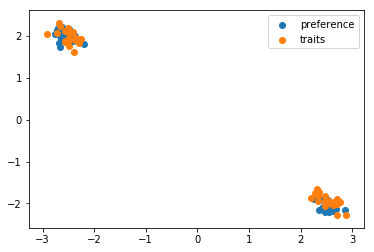

In [20]:
plt.figure()
plt.scatter(preferences_fake[:,0], preferences_fake[:,1],label='preference')
plt.scatter(traits_fake[:,0], traits_fake[:,1], label='traits')
plt.legend()

The preference and traits are nicely separated.

# Baseline
As a baseline implimentation we use the 

In [ ]:
print("Running Damped Baseline with beta=0...", end="")
model = DampedUserMovieBaselineModel(damping_factor=0)
#validator = PerformanceOverTimeValidator(model, n_year_period=2)
#years_4, errs_4 = validator.validate(ratings[['userId', 'movieId']], ratings['rating'], ratings['year'])
#print("Done!")
model.fit(train_set[['userId', 'movieId']], train_set['rating'])
baseline_prediction = model.predict(val_set[['userId', 'movieId']])
get_NDCG(baseline_prediction, val_set, k=10)

# Results

In [24]:
data, num_users, num_movies = generate_data_dict(train_set, val_set,n_traits=2)

In [25]:
%%time
#sampling takes forever here, but VB seems to work really well
#fit = sm.sampling(data=data, iter=100, algorithm="NUTS", chains=1, seed=seed, verbose=True)
fit = sm.vb(data=data,seed=seed)

CPU times: user 1min 34s, sys: 4.45 s, total: 1min 38s
Wall time: 1min 38s


In [26]:
predictions, probabilities = pystan_utils.vb_extract_predictions(fit)
get_precision(predictions,val_set)

0.6709791445740545

The precision is larger than random.

In [27]:
get_NDCG(probabilities,val_set, k=10)

0.8748873785032355

## Show preferences
Here the latent traits and preferences 

In [25]:
preferences=pystan_utils.vb_extract_variable(fit, 'preference[', var_type='matrix', dims=[num_users,2])
traits=pystan_utils.vb_extract_variable(fit, 'trait[', var_type='matrix', dims=[num_movies,2])

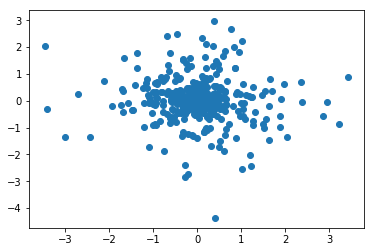

In [26]:
plt.figure()
plt.scatter(preferences[:,0], preferences[:,1])

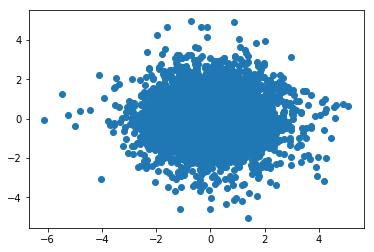

In [27]:
plt.figure()
plt.scatter(traits[:,0], traits[:,1])

Lets plot some extreme values of trait0. We would expect to see that the trait is discriminating between films using a latent trait of the film.

In [28]:
n_extreme = 10
sorted_trait_0_ids = np.argsort(traits[:,0])
lowest_ids = sorted_trait_0_ids[:n_extreme]+1
highest_ids = sorted_trait_0_ids[-n_extreme:]+1
lowest_movie_ids = [ id_movie_dict[lowest_id] for lowest_id in lowest_ids]
highest_movie_ids = [ id_movie_dict[highest_id] for highest_id in highest_ids]

In [29]:
movies[movies.movieId.isin(lowest_movie_ids)]

,movieId,title,genres
331,335,Underneath (1995),Mystery|Thriller
694,706,Sunset Park (1996),Drama
2449,2534,Avalanche (1978),Action
2533,2618,"Castle, The (1997)",Comedy
4403,4498,"Dead Pool, The (1988)",Action|Crime|Thriller
4693,4789,Phantom of the Paradise (1974),Comedy|Fantasy|Horror|Musical|Thriller
4767,4863,Female Trouble (1975),Comedy|Crime
10520,39427,Stay (2005),Thriller
11414,48883,Death of a President (2006),Crime|Drama|Mystery|Thriller
12968,61465,Bangkok Dangerous (2008),Action|Crime|Thriller


In [30]:
movies[movies.movieId.isin(highest_movie_ids)]

,movieId,title,genres
734,747,"Stupids, The (1996)",Comedy
1107,1130,"Howling, The (1980)",Horror|Mystery
1144,1167,Dear God (1996),Comedy
1840,1924,Plan 9 from Outer Space (1959),Horror|Sci-Fi
3199,3286,Snow Day (2000),Comedy
7719,8253,Lupin III: The Castle Of Cagliostro (Rupan san...,Action|Adventure|Animation|Comedy|Crime|Mystery
7763,8362,Raising Helen (2004),Comedy|Drama|Romance
8228,8911,Raise Your Voice (2004),Romance
11606,50802,Because I Said So (2007),Comedy|Drama|Romance
12461,58107,Step Up 2 the Streets (2008),Drama|Musical|Romance


By visual inspection of the low/high scoring, we cannot really see any latent trait that is used for discriminating.

Similar films should have similiar trait values. Therefore LOTR movies are inspected. 

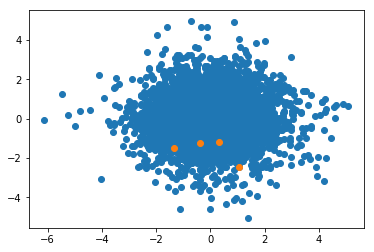

In [31]:
ids_lotr = [movie_id_dict[movie]-1 for movie in  movies[movies.title.str.contains('Lord of the Rings')].movieId]
plt.figure()
plt.scatter(traits[:,0], traits[:,1])
plt.scatter(traits[ids_lotr][:,0],traits[ids_lotr][:,1])

Plot the movies for which the porsterior of the traits has low variance

number of movies with low variance posteriors = 86


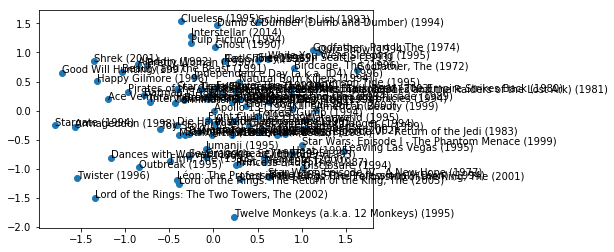

In [32]:
plot_low_variance_movies(fit,movies,num_movies,id_movie_dict)

Plotting traits and biases for some movies to see what dominates what.

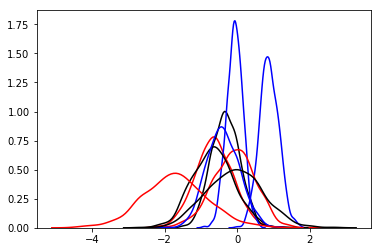

In [33]:
samples_var,means_var, stds_var, names_var=pystan_utils.vb_extract(fit)
plt.figure()
for i in range(1,4):
    sn.kdeplot(samples_var[f'trait_bias[{i}]'], color='b')
    sn.kdeplot(samples_var[f'trait[{i},1]'], color='r')
    sn.kdeplot(samples_var[f'trait[{i},2]'], color='k')

# Modelling stars

To model star ratings, instead of likes we need to change our model from a binary classification model, to a multivariate one.

This can be done by simply replacing the bernoulli distribution with a categorical to generate outputs between 1-10.
Now we however need to model the parameters of the categorical distribution. Our affinity variable is just a number, so a naive way would be to define parameters $\beta$ as 

$$
\mathbf{\beta}_c = [\beta_1, \beta_2, \dots , \beta_c] = w^T\text{affinity}
$$

where $w\in \mathbb{R}^C$


$$
star_{u,m} \sim categorical(star_{u,m} |\text{softmax}( \mathbf{w}^T\text{affinity}_{u,m}))
$$

In [10]:
model_definition = """ data {
    int num_movies;             // number of data items
    int num_traits;
    int num_users;  
    
    int num_likes;

    
    int stars_obs[num_likes];
    int userId_obs[num_likes];
    int movieId_obs[num_likes];
    
    int num_missing;
    int userId_missing [num_missing];
    int movieId_missing [num_missing];
    
}
parameters {
    matrix[num_movies,num_traits] trait;
    matrix[num_users ,num_traits] preference;
    vector[num_movies] trait_bias;
    vector[num_users] preference_bias;
    ordered[9] c;
    
} 

model {
    real affinity;

    for (n in 1:num_likes){
        affinity = 0;
        trait_bias[movieId_obs[n]] ~ normal(0,10);
        preference_bias[userId_obs[n]] ~ normal(0,10);
        for (t in 1:num_traits){
            preference[userId_obs[n], t] ~ normal(0,10);
 
            affinity += trait[movieId_obs[n], t]*preference[userId_obs[n], t];
            
        }
        affinity += trait_bias[movieId_obs[n]] + preference_bias[userId_obs[n]];
        
        stars_obs[n] ~ ordered_logistic(affinity,c);

    }
}

generated quantities {
    int predictions[num_missing];
    
    for(i in 1:num_missing){
        real affinity = 0;
        for (t in 1:num_traits){
            affinity += trait[movieId_missing[i], t] * preference[userId_missing[i], t];
        }
        affinity += trait_bias[movieId_missing[i]] + preference_bias[userId_missing[i]];
        predictions[i] = ordered_logistic_rng(affinity,c);
    }
}
"""

In [11]:
%%time
# create Stan model object
sm_stars = pystan.StanModel(model_code = model_definition)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f77195f23262559d1fba08bf46c26f9f NOW.


CPU times: user 1.5 s, sys: 176 ms, total: 1.67 s
Wall time: 1min 12s


In [12]:
data, num_users, num_movies = generate_data_dict(train_set, val_set,n_traits=2, stars=True)

In [13]:
%%time
#sampling takes forever here, but VB seems to work really well
#fit = sm.sampling(data=data, iter=100, algorithm="NUTS", chains=1, seed=seed, verbose=True)
fit_stars = sm_stars.vb(data=data,seed=seed)

CPU times: user 2min 5s, sys: 2.9 s, total: 2min 8s
Wall time: 2min 7s


In [15]:
predictions_stars, probabilities_stars = pystan_utils.vb_extract_predictions(fit_stars)


In [16]:
predictions_stars = [int(stars>=ratings_dict[3.5]) for stars in predictions_stars]
get_precision(predictions_stars,val_set)

0.6542948038176034

In [51]:
pystan_utils.vb_extract_variable(fit_stars, 'c', 'vector')

array([ 1.66039063e-02,  5.19675324e-04, -1.95207991e+00, ...,
        6.00000000e+00,  4.00000000e+00,  9.00000000e+00])

In [17]:
samples,_,_,_=pystan_utils.vb_extract(fit_stars)

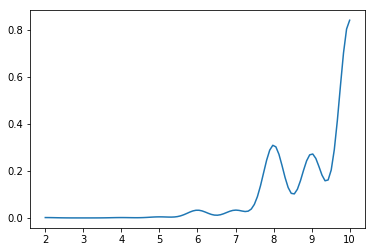

In [18]:
pystan_utils.plot_kde((samples['predictions[1]']))

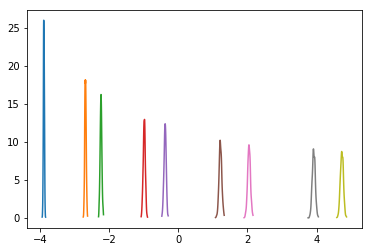

In [19]:
for i in range(1,10):
    pystan_utils.plot_kde( samples[f'c[{i}]'])

In [21]:
#Doesn't work for multiclass output at the momement
get_NDCG(probabilities_stars,val_set, k=10)

0.886062735496995

# Adding additional features

In [34]:
model_definition_genre = """ data {
    int num_movies;             // number of data items
    int num_traits;
    int num_users;  
    
    int num_likes;

    
    int stars_obs[num_likes];
    int userId_obs[num_likes];
    int movieId_obs[num_likes];
    
    int num_missing;
    int userId_missing [num_missing];
    int movieId_missing [num_missing];
    
    matrix[num_likes,20] genre;
    
}
parameters {
    matrix[num_movies,num_traits] trait;
    matrix[num_users ,num_traits] preference;
    vector[num_movies] trait_bias;
    vector[num_users] preference_bias;
    matrix[20,num_traits] genre_weight;
    vector[num_traits] genre_bias;
    ordered[9] c;
    
} 

model {
    real affinity;
    row_vector[num_traits] traitMean;
    
    genre_bias ~ normal(0,10);
    
    for (t in 1:num_traits){
        genre_weight[t] ~ normal(0,10);
    }
    
    
    

    for (n in 1:num_likes){
        affinity = 0;
        
        traitMean = genre[n]*genre_weight;
        
        trait_bias[movieId_obs[n]] ~ normal(0,10);
        preference_bias[userId_obs[n]] ~ normal(0,10);
        
        
        for (t in 1:num_traits){
            
            preference[userId_obs[n], t] ~ normal(0,10);
            trait[movieId_obs[n], t] ~ normal(traitMean[t] ,10);

            affinity += trait[movieId_obs[n], t]*preference[userId_obs[n], t];
            
        }
        affinity += trait_bias[movieId_obs[n]] + preference_bias[userId_obs[n]];
        
        stars_obs[n] ~ ordered_logistic(affinity,c);

    }
}

generated quantities {
    int predictions[num_missing];
    
    for(i in 1:num_missing){
        real affinity = 0;
        for (t in 1:num_traits){
            affinity += trait[movieId_missing[i], t] * preference[userId_missing[i], t];
        }
        affinity += trait_bias[movieId_missing[i]] + preference_bias[userId_missing[i]];
        predictions[i] = ordered_logistic_rng(affinity,c);
    }
}
"""

In [35]:
%%time
# create Stan model object
sm_genre = pystan.StanModel(model_code = model_definition_genre)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4a82915af22de64c4d0c84e11bda55f7 NOW.


CPU times: user 1.59 s, sys: 332 ms, total: 1.92 s
Wall time: 1min 28s


In [36]:
data, num_users, num_movies = generate_data_dict(train_set, val_set,n_traits=2, genre=True, stars=True) 

In [37]:
%%time
#sampling takes forever here, but VB seems to work really well
#fit = sm.sampling(data=data, iter=100, algorithm="NUTS", chains=1, seed=seed, verbose=True)
fit_genre = sm_genre.vb(data=data,seed=seed)

CPU times: user 3min 13s, sys: 5.74 s, total: 3min 19s
Wall time: 3min 19s


In [40]:
predictions_genre, probabilities_genre = pystan_utils.vb_extract_predictions(fit_genre)
predictions_genre = [int(stars>=ratings_dict[3.5]) for stars in predictions_genre]
get_precision(predictions_genre,val_set)

0.6582891481088724

The precision is larger than random.

In [39]:
get_NDCG(probabilities_genre,val_set, k=10)

0.8866588716412852

In [43]:
samples_var,means_var, stds_var, names_var=pystan_utils.vb_extract(fit_genre)

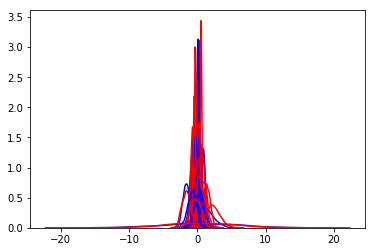

In [44]:
plt.figure()
for i in range(1,20+1):
    sn.kdeplot(samples_var[f'genre_weight[{i},1]'], color='b')
    sn.kdeplot(samples_var[f'genre_weight[{i},2]'], color='r')
    

# Questions

* *Expectation Propagation vs. Variational Bayes (10% difference in precision)?*
* *Does these values make sense (low ELBO)?*
```
Begin stochastic gradient ascent.
  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes 
   100     -3124403.404             1.000            1.000
   200     -1131926.528             1.380            1.760
   300     -1068337.903             0.940            1.000
   400     -1037532.838             0.712            1.000
   500      -982924.262             0.581            0.060
   600     -1024784.262             0.491            0.060
   700      -967588.749             0.429            0.059
   800      -966833.896             0.376            0.059
   900      -954641.153             0.335            0.056
  1000      -932961.912             0.304            0.056
  1100      -933640.840             0.204            0.041
  1200      -944417.031             0.029            0.030
  1300      -933809.949             0.025            0.023
  1400      -922032.712             0.023            0.013
  1500      -929080.979             0.018            0.013
  1600      -923651.819             0.015            0.011
  1700      -926248.001             0.009            0.011   MEAN ELBO CONVERGED
 ```
* *Should we care about symmetries?* 
```samples_dict, means_dict, var_names = pystan_utils.vb_extract(fit2)
pystan_utils.plot_kde(samples_dict['trait[1,1]'])
```
* *Why do we not get the same values for lotr in the plots*?